In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import math
from scipy import special

In [2]:
f = lambda x: x
q = np.polynomial.Chebyshev([1,1])
new = lambda x: q(x)*f(x)
print(new(3))
print(q)

12.0
cheb([1. 1.])


In [3]:
def funU(x,y):
    beta = 1/30
    a = np.array([-1,-1,-6.5,0.7])
    b = np.array([0,0,11,0.6])
    c = np.array([-10,-10,-6.5,0.7])
    D = np.array([-200,-100,-170,15])
    X = np.array([1,0,-0.5,-1])
    Y = np.array([0,0.5,1.5,1])
    gamma = 9
    k = 5
  
    fx1 = D[0]*np.exp(a[0]*((x-X[0])**2) + b[0]*(x-X[0])*(y-Y[0]) + c[0]*(y**2))
    fx2 = D[1]*np.exp(a[1]*((x-X[1])**2) + b[1]*(x-X[1])*(y-Y[1]) + c[1]*((y-Y[1])**2))
    fx3 = D[2]*np.exp(a[2]*((x-X[2])**2) + b[2]*(x-X[2])*(y-Y[2]) + c[2]*((y-Y[2])**2))
    fx4 = D[3]*np.exp(a[3]*((x-X[3])**2) + b[3]*(x-X[3])*(y-Y[3]) + c[3]*((y-Y[3])**2))
    extra = gamma*np.sin(2*k*math.pi*x)*np.sin(2*k*math.pi*y)
    
    U = fx1+fx2+fx3+fx4
#     U = U+extra
    U = np.exp(-beta*U)
    
    return U

In [4]:
def chebyshev_nodes(a, b, n):
    # n Chebyshev noder i intervallet [a, b]
    i = np.array(range(1,n))
    x = np.cos((2*i-1)*math.pi/(2*n)) # noder over intervallet [-1,1]
    return 0.5*(b-a)*x+0.5*(b+a) # noder over intervallet [a,b]

In [5]:
pol_deg_x = 19
pol_deg_y = 19
x_vec = chebyshev_nodes(-1.5,1,pol_deg_x*4)
y_vec = chebyshev_nodes(-0.5,2,pol_deg_y*4)

# x_vec = np.linspace(-1.5,1,pol_deg_x*2)
# y_vec = np.linspace(-0.5,2,pol_deg_y*2)

for xi in range(len(x_vec)):
    x = x_vec[xi]
    func_U_fix_x = funU(x,y_vec)
    coef = np.polynomial.chebyshev.chebfit(y_vec,func_U_fix_x,pol_deg_y-1)[:,None]
    if xi == 0:
        COEF = coef
    else: 
        COEF = np.column_stack((COEF,coef))
#     print(COEF.shape)
        
print(COEF.shape)

(19, 75)


In [6]:
# Take row vectors of COEF as function value at interpolation points
for yi in range(pol_deg_y):
    func_value = COEF[yi,:]
    curr_coef = np.polynomial.chebyshev.chebfit(x_vec,func_value,pol_deg_x-1)[:,None]
    if yi == 0:
        ALL_COEF = curr_coef
    else: 
        ALL_COEF = np.column_stack((ALL_COEF,curr_coef))
        
        
print(ALL_COEF.shape)

#ALL_COEF[j,k] represent the coefficient for kth phi(x) * jth psi(j)

(19, 19)


In [7]:
print(ALL_COEF.shape)

(19, 19)


In [8]:
# We deal with approximation of function and compare the difference
x = np.linspace(-1.5,1,41)
# x = 0.5*np.ones(41)
y = np.linspace(-0.5,2,41)
XX,YY = np.meshgrid(x,y)
XX = XX.ravel()
YY = YY.ravel()


In [9]:
def calc_pol(max_pol_deg):
    pol = []
    pol_deg = max_pol_deg+1
    coef = [1]
    for deg in range(pol_deg):
        p_deg = np.polynomial.chebyshev.Chebyshev(coef)
        pol.append(p_deg)
        coef.insert(0, 0)
    
    return pol

In [10]:
# A = calc_pol(19)

In [11]:
def all_pol(max_pol_deg_vec,d,beta,a = -1,b = 1):
    all_pol_M = []
    for i in range(d):
        max_pol_deg = max_pol_deg_vec[i]
        pol = calc_pol(max_pol_deg)
        
        all_pol_M.append(pol)
        
    return all_pol_M

In [12]:
chebys_x = calc_pol(pol_deg_x-1)
chebys_y = calc_pol(pol_deg_y-1)

# print(XX.shape)
# print(chebys_x[1](XX).shape)

In [13]:
estimate = 0
for j in range(pol_deg_y):
    for k in range(pol_deg_x):
        estimate += ALL_COEF[k,j]*chebys_x[k](XX)*chebys_y[j](YY)

In [14]:
actual = funU(XX,YY)
Diff = np.abs(actual - estimate)
RMSE = np.sqrt(np.mean(np.square(Diff)))
print(RMSE)

1.536186471162471


In [15]:
rel_error = RMSE/np.sqrt(np.mean(np.square(actual)))
print(rel_error)

0.09906217861611673


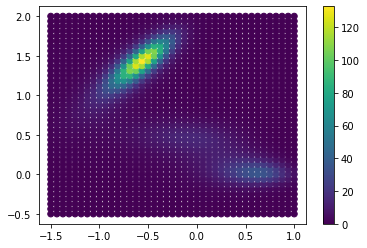

In [16]:
import matplotlib.pyplot as plt
plt.scatter(XX,YY,c = actual)
plt.colorbar()

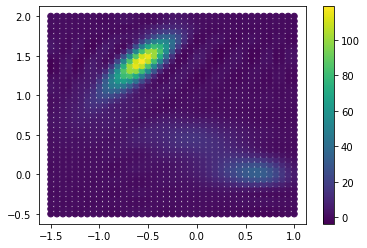

In [17]:
plt.scatter(XX,YY,c = estimate)
plt.colorbar()

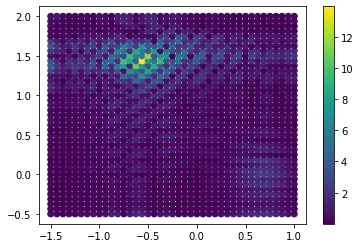

In [18]:
plt.scatter(XX,YY,c = Diff)
plt.colorbar()

In [19]:
## Decompose the matrix into product of two matrices
u, s, vh = np.linalg.svd(ALL_COEF)
P1 = u*s
P2 = vh

In [20]:
print(P1.shape)
print(P2.shape)

(19, 19)
(19, 19)
